In [10]:

import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K


def generate_loss_plot(history, filename=None):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    if (filename!=None):
        plt.savefig(filename)
    plt.show()


def generate_report(history, Y_train, Y_test, epochs):
    report_train = pd.DataFrame()
    report_train['mse'] = history.history['mse']
    report_train['RMSE'] = np.sqrt(pd.DataFrame(history.history['mse']))
    report_train['R2'] = history.history['r_square']
    report_train['actual'] = Y_train[:epochs]
    
    report_test = pd.DataFrame()
    report_test['mse'] = history.history['val_mse']
    report_test['RMSE'] = np.sqrt(pd.DataFrame(history.history['val_mse']))
    report_test['R2'] = history.history['val_r_square']
    report_test['actual'] = Y_test[:epochs]
    return report_train, report_test

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def get_data(): 
    df = pd.read_csv('pluto5_stddum.csv')
    df.drop(['assessland'], axis=1, inplace=True)
    
    X = df[df.columns]
    X.drop('assesstot', axis=1, inplace=True)
    predictors = X.columns
    X = X.values
    Y = df['assesstot'].values
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    return x_train, x_test, y_train, y_test, predictors

#3)Adam combines the good properties of Adadelta and RMSprop and hence tend to do better for most of the problems.
def fit_model(model, x_train, x_test, y_train, y_test, epochs):
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', r_square])
    history = model.fit(x_train, y_train, epochs=epochs, verbose=0, validation_data=(x_test, y_test))
    generate_loss_plot(history, filename=None)
    report_train, report_test = generate_report(history, y_train, y_test, epochs)
    return model, report_train, report_test


def predict(model, x, y, filename=None):
    y_pred = model.predict(x)
    fig, ax = plt.subplots()
    ax.plot(y, color = 'blue')
    ax.plot(y_pred, color = 'red')
    ax.legend(['Real', 'Predicted'])
    if (filename!=None):
        fig.savefig(filename)
    plt.show()
    return y_pred
    
def print_errors(report, y_pred, y_actual, epochs):
    report['error'] = report['actual'] - pd.DataFrame(y_pred[:epochs])[0]
    print(report[['mse','RMSE','R2', 'error']].mean())
    #TODO: plt.hist((y-y_actual), bins='auto')
    return report

def get_means(reports, metric):
    means = []
    for report in reports:
        means.append(report[[metric]].mean()[0])
    return means
        
def calculate_best(reports):
    rmse_values = get_means(reports, 'RMSE')
    print('index=', rmse_values.index(min(rmse_values)), 'value=', min(rmse_values))
    r2_values = get_means(reports, 'R2')
    print('index=', r2_values.index(min(r2_values)), 'value=', max(r2_values))

def run_model(hidden_nodes, x_train, x_test, y_train, y_test, epochs):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(input_nodes, tf.keras.activations.linear))
    model.add(tf.keras.layers.Dense(hidden_nodes, tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(1, tf.keras.activations.linear))
    model, report_train, report_test = fit_model(model, x_train, x_test, y_train, y_test, epochs)
    y_pred = predict(model, x_test, y_test)
    report_test = print_errors(report_test, y_pred, y_test, epochs)
    return report_train, report_test


In [3]:
x_train, x_test, y_train, y_test, predictors = get_data()
input_nodes = len(predictors)
epochs = 20
reports = []

Model 0


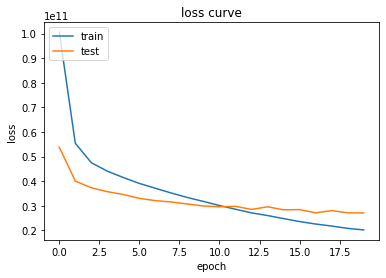

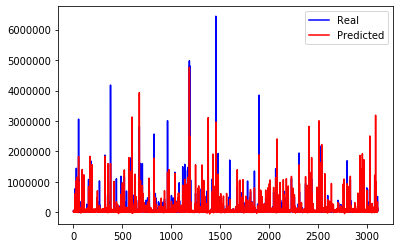

mse      3.210355e+10
RMSE     1.784946e+05
R2      -1.801545e-01
error    1.014264e+04
dtype: float64


In [4]:

#choose the amount of nodes in hidden layers: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html
#NN0: 1 hidden layer with (Number of inputs + outputs) * (2/3) nodes: overfitting
#does not predicts well high values but it might be because sample 
print('Model 0')
report_train, report_test = run_model(int((input_nodes+1)*(2/3)), x_train, x_test, y_train, y_test, epochs)
reports.append(report_test)

Model 1


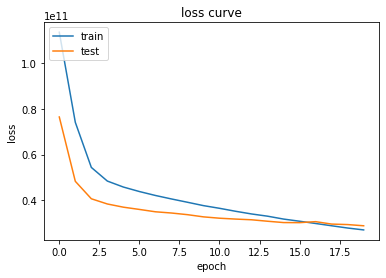

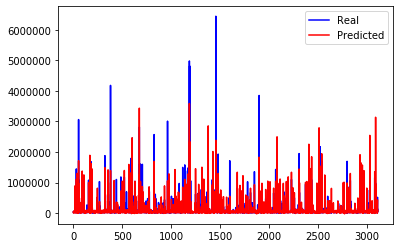

mse      3.582994e+10
RMSE     1.878176e+05
R2      -6.852946e-02
error   -5.503579e+03
dtype: float64


In [5]:
#NN1: # A typical recommendation is that
#the number of weights should be no more than 1/30 of the number of training cases: underfitting
print('Model 1')
report_train, report_test = run_model(int(len(x_train)/(30*2)), x_train, x_test, y_train, y_test, epochs)
reports.append(report_test)

Model 2


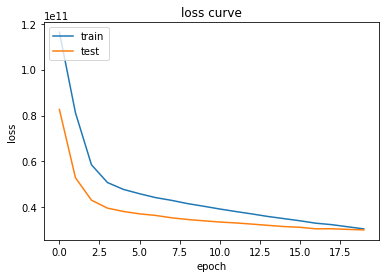

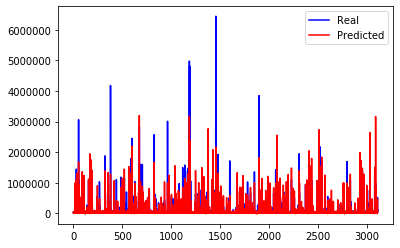

mse      3.750433e+10
RMSE     1.919627e+05
R2      -4.655228e-01
error   -8.770743e+03
dtype: float64


In [6]:
#NN2: reduce amount of nodes hidden layer: underfitting
print('Model 2')
report_train, report_test = run_model(int(len(x_train)/(30*4)), x_train, x_test, y_train, y_test, epochs)
reports.append(report_test)

Model 3


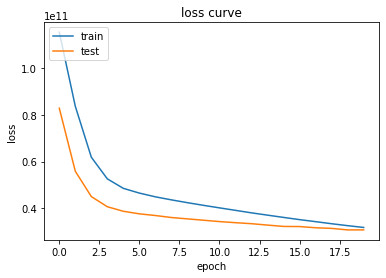

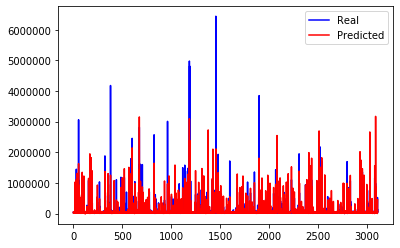

mse      3.835211e+10
RMSE     1.941392e+05
R2      -2.511304e-01
error   -1.125797e+04
dtype: float64


In [7]:
#NN3: reduce amount of nodes hidden layer: underfitting
print('Model 3')
report_train, report_test = run_model(int(len(x_train)/(30*6)), x_train, x_test, y_train, y_test, epochs)
reports.append(report_test)

Model 4


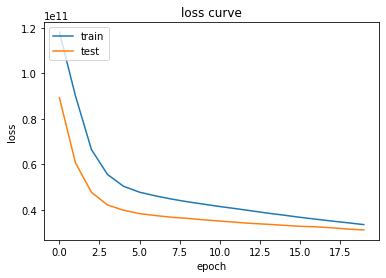

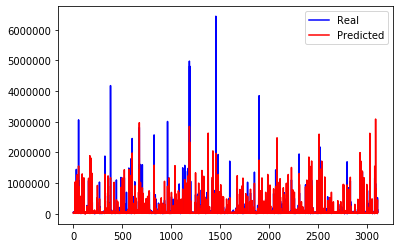

mse      3.972962e+10
RMSE     1.973194e+05
R2      -2.561575e-01
error   -9.403997e+03
dtype: float64


In [8]:
#NN4: reduce amount of nodes hidden layer: underfitting
print('Model 4')
report_train, report_test = run_model(int(len(x_train)/(30*8)), x_train, x_test, y_train, y_test, epochs)
reports.append(report_test)


In [9]:
#choose the best
calculate_best(reports)

index= 0 value= 178494.64549523307
index= 2 value= -0.0685294607654214


Model 5


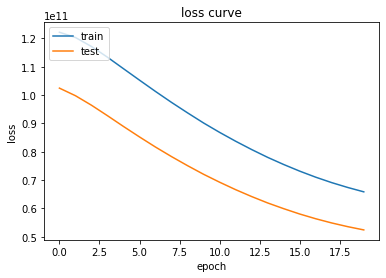

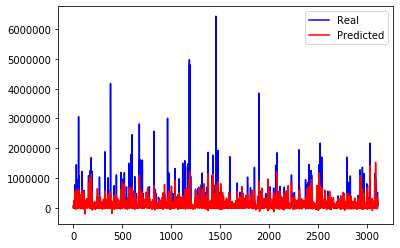

mse      7.349998e+10
RMSE     2.695396e+05
R2      -3.473005e-01
error   -1.463017e+03
dtype: float64


In [12]:
#NN5: without hidden layer: predicts really bad
print('Model 5')
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(input_nodes, tf.keras.activations.linear))
model.add(tf.keras.layers.Dense(1, tf.keras.activations.linear))
model, report_train, report_test = fit_model(model, x_train, x_test, y_train, y_test, epochs)
y_pred = predict(model, x_test, y_test)
report_test = print_errors(report_test, y_pred, y_test, epochs)

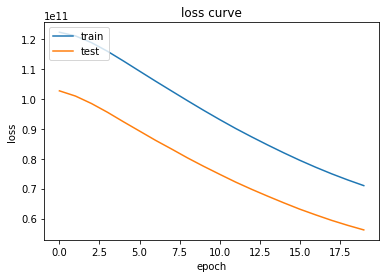

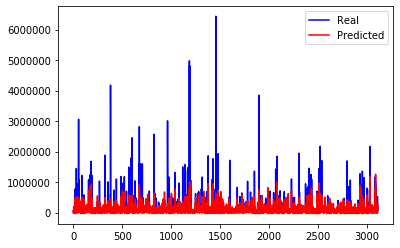

mse      7.766682e+10
RMSE     2.774165e+05
R2      -1.747398e-01
error    5.916997e+03
dtype: float64


In [13]:
#only 2 layers relu: predicts really bad
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(input_nodes, tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(1, tf.keras.activations.linear))
model, report_train, report_test = fit_model(model, x_train, x_test, y_train, y_test, epochs)
y_pred = predict(model, x_test, y_test)
report_test = print_errors(report_test, y_pred, y_test, epochs)

In [ ]:
#TODO: read optimizer
#https://towardsdatascience.com/how-to-train-neural-network-faster-with-optimizers-d297730b3713
#https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3
